## Example 3: Single Inclusive Multiplicity

In this example, we calculate the single inclusive particle production as a function of the incident and target saturation scale.

### References

Schlichting, S., & Skokov, V. (2020). Saturation corrections to dilute-dense particle production and azimuthal correlations in the Color Glass Condensate. Physics Letters B, 806, 135511. https://doi.org/10.1016/j.physletb.2020.135511 (https://arxiv.org/pdf/1910.12496.pdf)


In [3]:
# If you haven't formally installed the toolbox, you will need
# this line to get proper access to the functions
import sys
sys.path.append('../')

# Import our functions
import cgc

# To make the evaluation responsive and more user friendly
# Can be installed with: pip install progressbar2
import progressbar

# Import numpy and matplotlib for plotting/other utility
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.fft import fft2, ifft2
from scipy.interpolate import splrep, sproot

# Make our plots nice and large
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 12

## Varying the target saturation scale

In [32]:
M = 5 # Number of configurations per saturation scale
N = 128  # Lattice size
L = 32
delta = L/N
radius = 12

# We vary mu to change the saturation scale
muNArr = np.linspace(1, 2, 10)
muP = 1 # Proton Qs should stay constant

# Collecting and storing configurations of the fundamental Wilson line in real space
V_list = np.zeros([len(muNArr), M, N, N, 3, 3], dtype=np.complex128) # The wilson line is a 3x3 matrix at each lattice point
particleProduction = np.zeros(len(muNArr))

# This step may take a while, so we'll use a progress bar to see how far along we are
# We'll use this several times later on as well
progressBar = progressbar.ProgressBar(max_value=M*len(muNArr))

# Generate M targets and calculate their Wilson lines
for i in range(len(muNArr)):
    for m in range(M):
        progressBar.update(i*M + m)
        proton = cgc.Proton(3, N, delta, muP, radius, M=0.1)
        nucleus = cgc.Nucleus(3, N, delta, muNArr[i], M=0.1, Ny=100)
        
        # Store the wilson line to calculate Qs
        V_list[i,m] = nucleus.wilsonLine()
        
        # Calculate the single inclusive particle production
        col = cgc.Collision(nucleus, proton)
        # Take \int dN/dk * dk = \sum_k dN/dk (k) * k
        particleProduction[i] += np.sum(col.particlesProduced() * col.momentaBins()) / M
        
progressBar.update(M*len(muNArr))

100% (50 of 50) |########################| Elapsed Time: 0:08:49 ETA:  00:00:00

Now we calculate the saturation momentum; see the example about this for more detail.

In [33]:
QsArr = np.zeros(len(muNArr))

V_fft = fft2(V_list, axes=(2,3),
             workers=-1, # For parallelization
            ) 

rComSqr = (np.arange(N)*delta)**2
rMag = np.sqrt(np.add.outer(rComSqr, rComSqr))

# The center of each bin
r = delta*(np.arange(int(N/2))+0.5)

for q in range(len(QsArr)):

    # Evaluating the S matrix in momentum and configuration spaces  
    S = np.zeros([N, N], dtype=np.complex128)
    S_fft = np.zeros([N, N], dtype=np.complex128)

    for i in range(N):
        for j in range(N):
            S_fft[i,j] += np.sum([np.trace(V_fft[q,m,i,j] @ np.conjugate(np.transpose(V_fft[q,m,i,j]))) for m in range(M)])

    # Forward norm means no extra factors on the ifft (since we put them in explicitly)
    S = ifft2(S_fft, norm='forward') / (3 * M * N**4)
    S_fft *= delta**2 / (3 * M * N**2)

    # binning and defining the ratio g^2 mu/Qs via S( g^2 \mu r_s )   = e^{-1/2} with Q_s r_s = sqrt(2)
    # or Q_s/(g^2 \mu)   (r_s g^2 \mu) = sqrt(2) thus  g^2 \mu/Q_s = 1/sqrt(2)  (r_s g^2 \mu) 
    S_b = np.zeros(int(N/2), dtype='float')
    n_b = np.zeros(int(N/2), dtype='float')

    for i in range(int(N/2)):
        # Boolean expression finds the points that are between delta*i and delta*(i+1)
        n_b[i] = len(S[(rMag < delta * (i+1)) & (rMag >= delta * i)])
        S_b[i] = np.sum(np.real(S[(rMag < delta * (i+1)) & (rMag >= delta * i)])) / n_b[i]

    # Now do the interpolation
    tck = splrep(r, S_b - np.exp(-0.5), s=0)
    try:
        muOverQs = muNArr[q] / sproot(tck)[0]/np.sqrt(2)

        # Since g = 1
        QsArr[q] = muNArr[q] / muOverQs
    except:
        QsArr[q] = 0

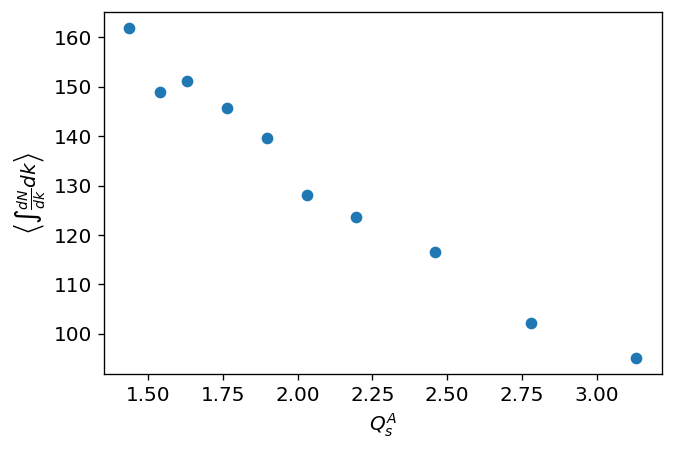

In [36]:
plt.plot(QsArr, particleProduction, 'o')
plt.xlabel('$Q^A_s$')
plt.ylabel(r'$\left\langle \int \frac{dN}{dk} dk \right\rangle$')
plt.savefig('single_inclusive_1.png')
plt.show()